# Анализ поведения пользователей в мобильном приложении


## Описание проекта

Задачи:
1. Проанализировать связь целевого события — просмотра контактов — и других
действий пользователей.
2. Оценить, какие действия чаще совершают те пользователи, которые
просматривают контакты.

Этапы исследования:
Проведите исследовательский анализ данных
Проанализируйте влияние событий на совершение целевого события
Проверьте статистические гипотезы
1. Одни пользователи совершают действия `tips_show` и `tips_click` , другие —
только `tips_show` . Проверьте гипотезу: конверсия в просмотры контактов
различается у этих двух групп.
2. Формулировка собственной статистической гипотезы. Дополние её
нулевой и альтернативной гипотезами. Проверка гипотезы с помощью
статистического теста.
3. Итоговая презентация

Описание данных:
Датасет содержит данные о событиях, совершенных в мобильном приложении
"Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая
Мобильные приложения — Анализ поведения пользователей в мобильном приложении 2
их на доске объявлений.
В датасете содержатся данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.

Колонки в [/datasets/mobile_sources.csv](https://code.s3.yandex.net/datasets/mobile_sources.csv);
- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в [/datasets/mobile_dataset.csv](https://code.s3.yandex.net/datasets/mobile_dataset.csv);
- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:
- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1` — `search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

## Импорт библиотек

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import chart_studio
from datetime import timedelta

# Сделаем небольшие настройки для комфортного отображения проекта
import warnings; warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('dark_background')

## Выгрузка и первичный осмотр данных

In [2]:
print('Загружаем датасет "mobile_dataset.csv"')
try:
    m_ds_path = os.path.join('datasets/mobile_dataset.csv')
    m_ds = pd.read_csv(m_ds_path)
    print('данные загружены с локального хранилища')
except:
    m_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
    print('данные загружены с сервера')

print('Загружаем датасет "mobile_sources.csv"')
try:
    m_src_path = os.path.join('datasets/mobile_sources.csv')
    m_src = pd.read_csv(m_src_path)
    print('данные загружены с локального хранилища')
except:
    m_src = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')
    print('данные загружены с сервера')

Загружаем датасет "mobile_dataset.csv"
данные загружены с локального хранилища
Загружаем датасет "mobile_sources.csv"
данные загружены с локального хранилища


In [3]:
# смотрим общую информацию по датасетам
df_list = [m_ds, m_src]
df_name = ['mobile_dataset', 'mobile_source']

for i,n in zip(df_list, df_name):
    text = f'  информация по датасету {n}  '
    print(f'{text:~^79}')
    display(i.info())
    display(i.head(5))
    display(i.describe())

~~~~~~~~~~~~~~~~~~~  информация по датасету mobile_dataset  ~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,event.time,event.name,user.id
count,74197,74197,74197
unique,74197,16,4293
top,2019-10-07 00:00:00.431357,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478


~~~~~~~~~~~~~~~~~~~  информация по датасету mobile_source  ~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


,userId,source
count,4293,4293
unique,4293,3
top,020292ab-89bc-4156-9acf-68bc2783f894,yandex
freq,1,1934


Датасет `mobile_dataset` соответствует описанию и содержит 3 столбца. Названия столбцов следует изменить, столбец `event.time` привести к формату datetime.

Датасет `mobile_source` соответствует описанию и содержит 2 столбца. Количество записей соответствует количеству уникальных значений `user.id` в датасете `mobile_dataset`.

Пропусков в датасетах нет.

Итого мы имеем:
* 4293 уникальных пользователя
* 74197 события

Посмотрим на уникальные значения столбцов с событиями и источниками пользователей

In [4]:
display(m_ds['event.name'].unique())
display(m_src['source'].unique())

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

array(['other', 'yandex', 'google'], dtype=object)

`contacts_show` и `show_contacts` необходимо объединить т.к. это одно и то же событие

Проверим датасеты на наличие явных дубликатов

In [5]:
for i, n in zip(df_list, df_name):
    print('дубликатов в датасете ' + n + ':', i.duplicated().sum())

дубликатов в датасете mobile_dataset: 0
дубликатов в датасете mobile_source: 0


## Предобработка данных

### Переименуем столбцы

In [6]:

m_ds = m_ds.rename(columns={'event.time': 'event_time', 'event.name': 'event_name', 'user.id': 'user_id'})
m_src = m_src.rename(columns={'userId': 'user_id', 'source': 'mobile_source'})

### Заменим тип данных на в столбце `event_time` на `datetime`

In [7]:

m_ds['event_time'] = pd.to_datetime(m_ds['event_time'])

### Объединим датасеты для удобства

In [8]:

mob = m_ds.merge(m_src, on='user_id', how='left')

In [9]:
mob.info()
display(mob.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   event_time     74197 non-null  datetime64[ns]
 1   event_name     74197 non-null  object        
 2   user_id        74197 non-null  object        
 3   mobile_source  74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.3+ MB


,event_time,event_name,user_id,mobile_source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


### Переименуем события, приводя их к единому формату

In [10]:
mob['event_name'][mob['event_name'] == 'show_contacts'] = 'contacts_show'
mob['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

Итак, мы переименовали столбцы, поле с датой и временем привели к удобному формату, объединили все данные в один датафрейм, привели названия целевого события к единому формату и проверив как выглядят данные можно приступить к анализу.

## Анализ данных

In [11]:
display(mob['event_time'].describe())

print('начальная дата:', mob['event_time'].min().strftime('%d %b %Y (%a)'))
print('конечная дата:', mob['event_time'].max().strftime('%d %b %Y (%a)')) 

count                            74197
mean     2019-10-21 15:32:09.039316992
min         2019-10-07 00:00:00.431357
25%      2019-10-14 22:04:27.791869952
50%      2019-10-22 00:26:56.715014912
75%      2019-10-28 12:35:53.023877120
max         2019-11-03 23:58:12.532487
Name: event_time, dtype: object

начальная дата: 07 Oct 2019 (Mon)
конечная дата: 03 Nov 2019 (Sun)


В нашем распоряжении информация с `07 Oct 2019` по `03 Nov 2019`, то есть почти за месяц

In [12]:
te_conv = len(mob[mob['event_name'] == 'contacts_show']['user_id'].unique()) / len(mob['user_id'].unique())
print(f'Конверсия к целевому событию - {round(te_conv*100, 2)}%')

Конверсия к целевому событию - 22.85%


### Посмотрим частоту каждого типа событий

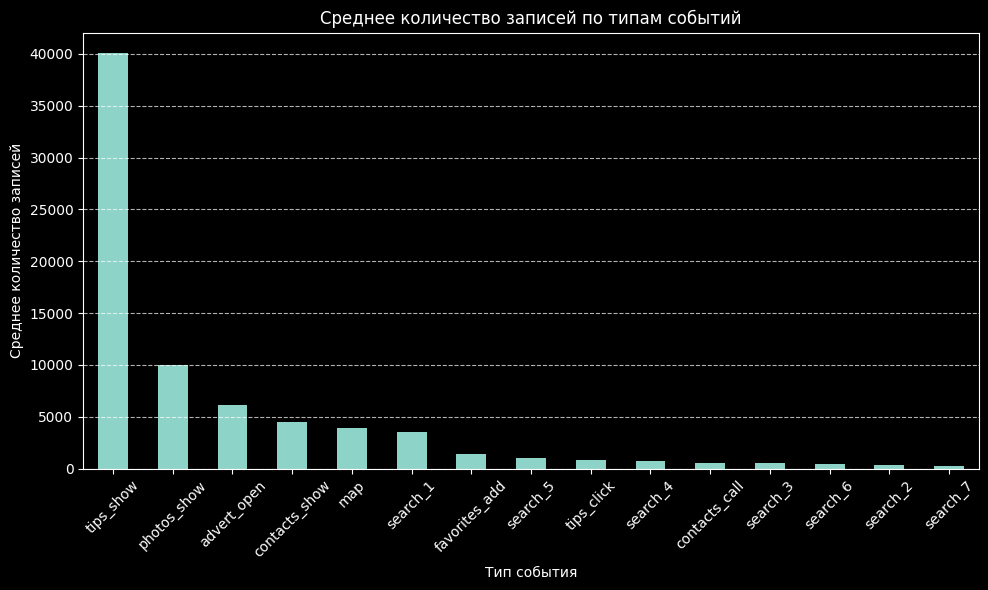

In [13]:
plt.figure(figsize=(10, 6))
mob['event_name'].value_counts().plot(kind='bar')
plt.title('Среднее количество записей по типам событий')
plt.xlabel('Тип события')
plt.ylabel('Среднее количество записей')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Событие `tips_show` происходит слишком часто, что подразумевает его автоматический характер, и рекомендации выводятся пользователям постоянно в процессе использования приложения. Поскольку мы интересуемся действиями пользователей, а отображение рекомендаций не зависит от них, данное событие не пригодно для анализа.

Отсутствует начальное событие, которое можно было бы использовать в качестве отправной точки для воронки и точно отражало бы количество посещений приложения. Например, "Открытие главной страницы".

Событие `search_1` встречается значительно чаще других, что вероятно свидетельствует о взаимодействии с поисковой строкой, в то время как остальные 6 поисковых событий скорее относятся к более специализированным действиям, таким как использование фильтров и другие. Всего таких специализированных событий немного, поэтому для упрощения их можно объединить в одно событие.

In [14]:
mob_with_tips_show = mob.copy()
mob = mob[mob['event_name'] != 'tips_show']
mob.loc[mob['event_name'] == 'search_1', 'event_name'] = 'search_simple'
mob.loc[mob['event_name'].isin(['search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']), 'event_name'] = 'search_special'

### Посмотрим, сколько в среднем событий приходится на одного пользователя

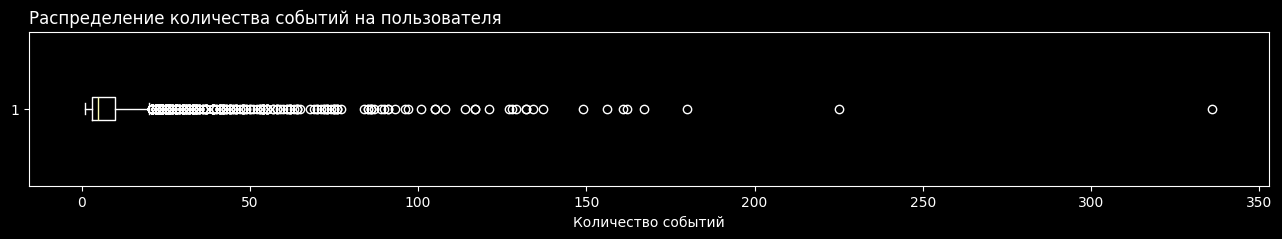

In [15]:
events_by_user = mob.groupby('user_id').agg(event_count = ('event_time', 'count')).reset_index()

plt.figure(figsize=(16, 2))
plt.title('Распределение количества событий на пользователя', loc='left')
plt.boxplot(events_by_user['event_count'], vert=False)
plt.xlabel('Количество событий')
plt.show();

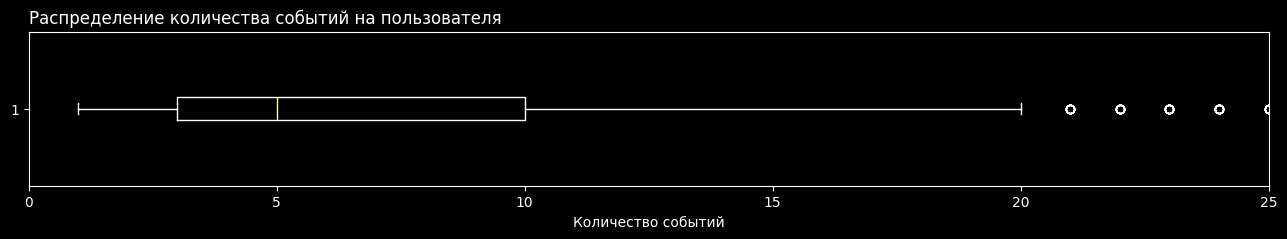

count   3586.0000
mean       9.5209
std       16.3181
min        1.0000
25%        3.0000
50%        5.0000
75%       10.0000
max      336.0000
Name: event_count, dtype: float64

In [16]:
plt.figure(figsize=(16, 2))
plt.title('Распределение количества событий на пользователя', loc='left')
plt.boxplot(events_by_user['event_count'], vert=False)
plt.xlabel('Количество событий')
plt.xlim(0, 25) # увеличим масштаб
plt.show();

display(events_by_user['event_count'].describe())

На одного пользователя приходится событий:
- В среднем - 16;
- Минимум - 1;
- максимум - 336;
- медиана - 5

### Посмотрим на распределение данных по источнику, с которого пользователь установил приложение

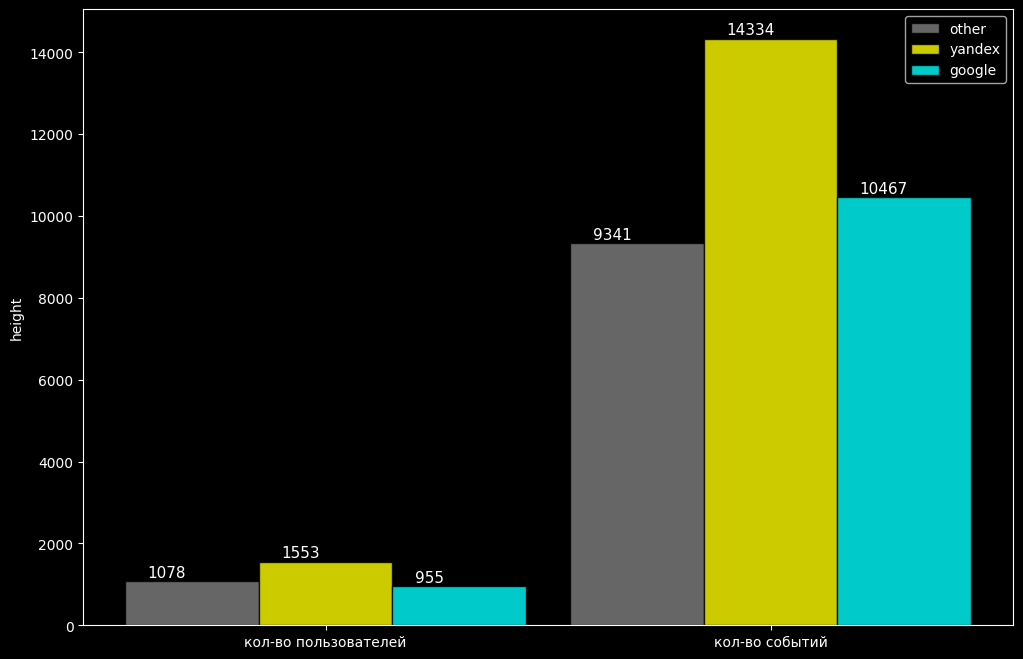

In [17]:
barWidth = 0.3
bars = [[] * n for n in range(len(mob['mobile_source'].unique()))]

for i in range(len(mob['mobile_source'].unique())):
    bars[i].append(mob.groupby('mobile_source', sort=False).agg({'user_id': 'nunique'})['user_id'][i])
    bars[i].append(mob.groupby('mobile_source', sort=False).agg({'user_id': 'count'})['user_id'][i])

r = [[0] * n for n in range(len(mob['mobile_source'].unique()))]
r[0] = np.arange(len(bars[0]))

for i in range(1, len(mob['mobile_source'].unique())):
    r[i] = [x + barWidth for x in r[i-1]]

plt.figure(figsize=(12, 8))
plt.bar(r[0], bars[0], width = barWidth, color = 'grey', edgecolor = 'black', capsize=7, alpha=0.8, label=mob['mobile_source'].unique()[0])
plt.bar(r[1], bars[1], width = barWidth, color = 'yellow', edgecolor = 'black', capsize=7, alpha=0.8, label=mob['mobile_source'].unique()[1])
plt.bar(r[2], bars[2], width = barWidth, color = 'cyan', edgecolor = 'black', capsize=7, alpha=0.8, label=mob['mobile_source'].unique()[2])

plt.xticks([r + barWidth for r in range(len(bars[0]))], ['кол-во пользователей', 'кол-во событий'])
plt.ylabel('height')
plt.legend()
for i in range(len(bars)):
    for j in range(len(bars[0])):
        plt.text(x = r[i][j]-0.1 , y = bars[i][j]+100, s = bars[i][j], size = 11)
plt.show()

По обоим показателям лидирует Yandex. Google даёт меньше уникальных пользователей чем остальные источники (не считая Yandex), но эти пользователи чуть более активны

### Посмотрим на распределение событий во времени

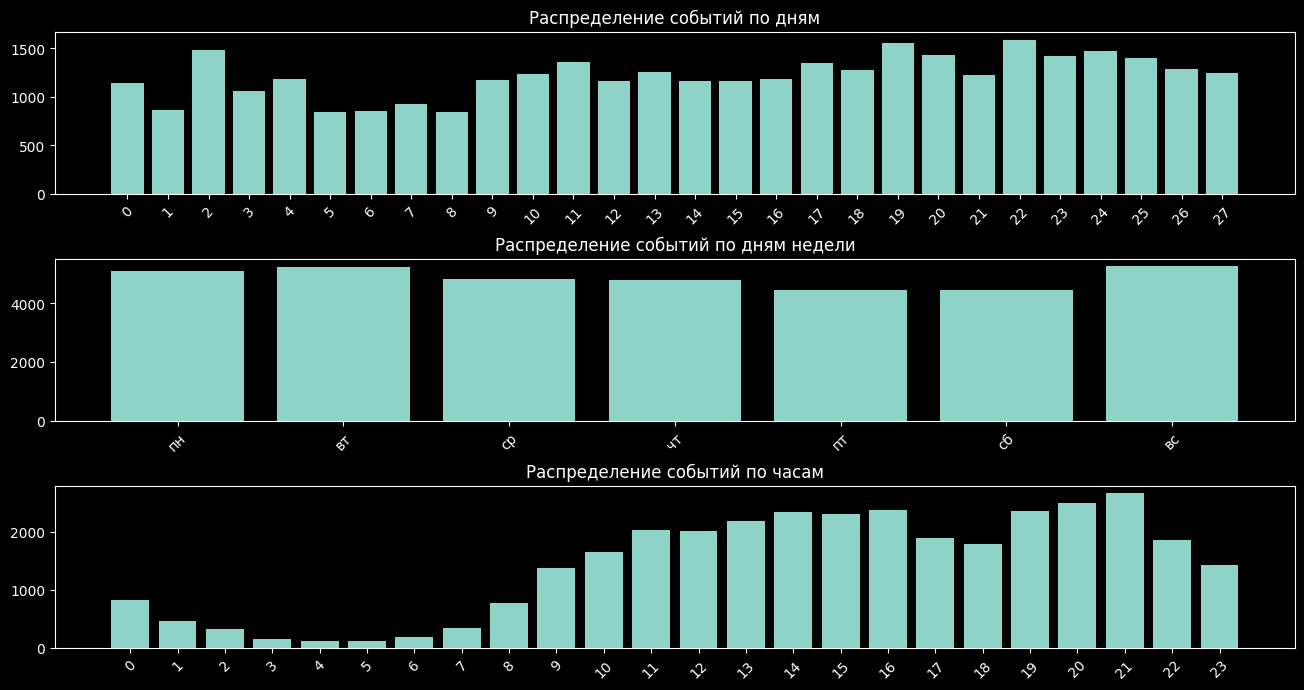

In [18]:
period = (mob['event_time'].max() - mob['event_time'].min()).days
week = ('пн','вт','ср','чт','пт','сб','вс')
pos_p = np.arange(period+1)
pos_w = np.arange(len(week))
pos_h = np.arange(24)


fig = plt.figure(figsize=(16, 8))
plt.subplot(3,1, 1)
plt.bar(pos_p, mob['event_time'].dt.day.value_counts().sort_index())
plt.title('Распределение событий по дням')
plt.xticks(pos_p, pos_p, rotation=45)

plt.subplot(3,1, 2)
plt.bar(pos_w, mob['event_time'].dt.weekday.value_counts().sort_index())
plt.title('Распределение событий по дням недели')
plt.xticks(pos_w, week, rotation=45)

plt.subplot(3,1, 3)
plt.bar(pos_h, mob['event_time'].dt.hour.value_counts().sort_index())
plt.title('Распределение событий по часам')
plt.xticks(pos_h, pos_h, rotation=45)

plt.subplots_adjust(hspace = 0.4)
plt.show();

Ночью приложением пользуются значительно реже и пик приходится на 9 вечера. Так же есть провал в 5-6 вечера.

Никаких сильных отклонений не видно. Есть суточная сезонность. Ввиду небольшого отрезка данных по времени, делать декомпозицию и выявлять тренды не резонно.

### Выделение сессий

#### Разобьем события по сессиям

По стандарту [OWASP (Open Web Application Security Project)](https://cheatsheetseries.owasp.org/cheatsheets/Session_Management_Cheat_Sheet.html#:~:text=Both%20the%20idle,and%208%20hours) рекомендуется использовать интервал между сессиями от 2 до 5 минут для приложений с высоким уровнем безопасности и от 15 до 30 минут для обычных приложений. Наше мобильное приложение "Ненужные вещи" не требует высокого уровня защиты, поэтому мы выбрали время неактивности пользователей 20 минут. Однако, чтобы узнать более точное время сессии данного приложения, лучше всего обратиться к разработчикам.

In [19]:
g = (mob.groupby('user_id')['event_time'].diff() > pd.Timedelta('20Min')).cumsum()
mob = mob.sort_values(['user_id', 'event_time'])
mob['session_id'] = mob.groupby(['user_id', g], sort=False).ngroup() + 1

#### Посмотрим на полученные сессии

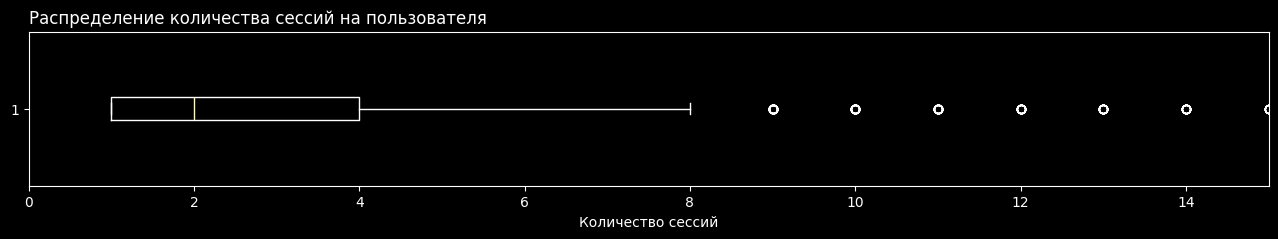

In [20]:
plt.figure(figsize=(16, 2))
plt.title('Распределение количества сессий на пользователя', loc='left')
plt.boxplot(mob.groupby('user_id')['session_id'].nunique(), vert=False)
plt.xlabel('Количество сессий')
plt.xlim(0, 15) # увеличим масштаб
plt.show();

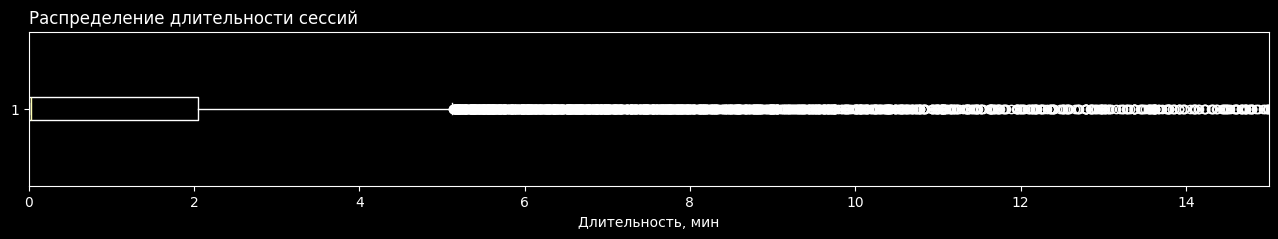

In [21]:
plt.figure(figsize=(16, 2))
plt.title('Распределение длительности сессий', loc='left')
plt.boxplot(mob.groupby(['session_id', 'user_id'])
            .agg(time_span=('event_time', lambda x: (x.max() - x.min())/np.timedelta64(60, 's'))), vert=False)
plt.xlabel('Длительность, мин')
plt.xlim(0, 15) # увеличим масштаб
plt.show();

Основная масса людей пользуется приложением до 2 минут 1-4 раз в день.

Длительность сессии может зависеть от различных факторов. Однако, обычно для мобильных приложений цель состоит в том, чтобы обеспечить комфортное и продуктивное взаимодействие пользователей с приложением. Это означает, что длительность сессии должна быть достаточной для выполнения основных задач пользователей, но при этом не слишком долгой, чтобы не утомлять пользователей.

В случае мобильного приложения по обмену вещами, хорошей длительностью сессии может быть примерно 5-15 минут. Этот интервал дает пользователям достаточно времени для просмотра предложений, добавления или просмотра своих объявлений, общения с другими пользователями и выполнения других основных действий, но не настолько долгий, чтобы вызывать усталость или скуку.

Я бы посоветовала задуматься над удержанием пользователей.

### Удержание

In [22]:
profiles = (mob.sort_values(by=['user_id', 'event_time']).groupby('user_id')
            .agg({'event_time': 'first'}).rename(columns={'event_time': 'first_join'}).reset_index())
profiles['dt'] = pd.to_datetime(profiles['first_join'].dt.date)
profiles['month'] = profiles['first_join'].dt.strftime('%m')
last_date = mob['event_time'].max().date() - timedelta(days=13)
profiles = profiles.query('dt <= @last_date')
profiles = profiles.merge(mob[['user_id', 'event_time']], on='user_id', how='left')
profiles['lifetime'] = (profiles['event_time'] - profiles['first_join']).dt.days
profiles_pivot = profiles.pivot_table(index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique')
cohort_sizes = (profiles.groupby('dt').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'}))
profiles_pivot = cohort_sizes.merge(profiles_pivot, on='dt', how='left').fillna(0)
profiles_pivot = profiles_pivot.div(profiles_pivot['cohort_size'], axis=0)
profiles_pivot = profiles_pivot[['cohort_size'] + list(range(14))]
profiles_pivot['cohort_size'] = cohort_sizes
profiles_pivot.index = profiles_pivot.index.strftime('%m/%d')

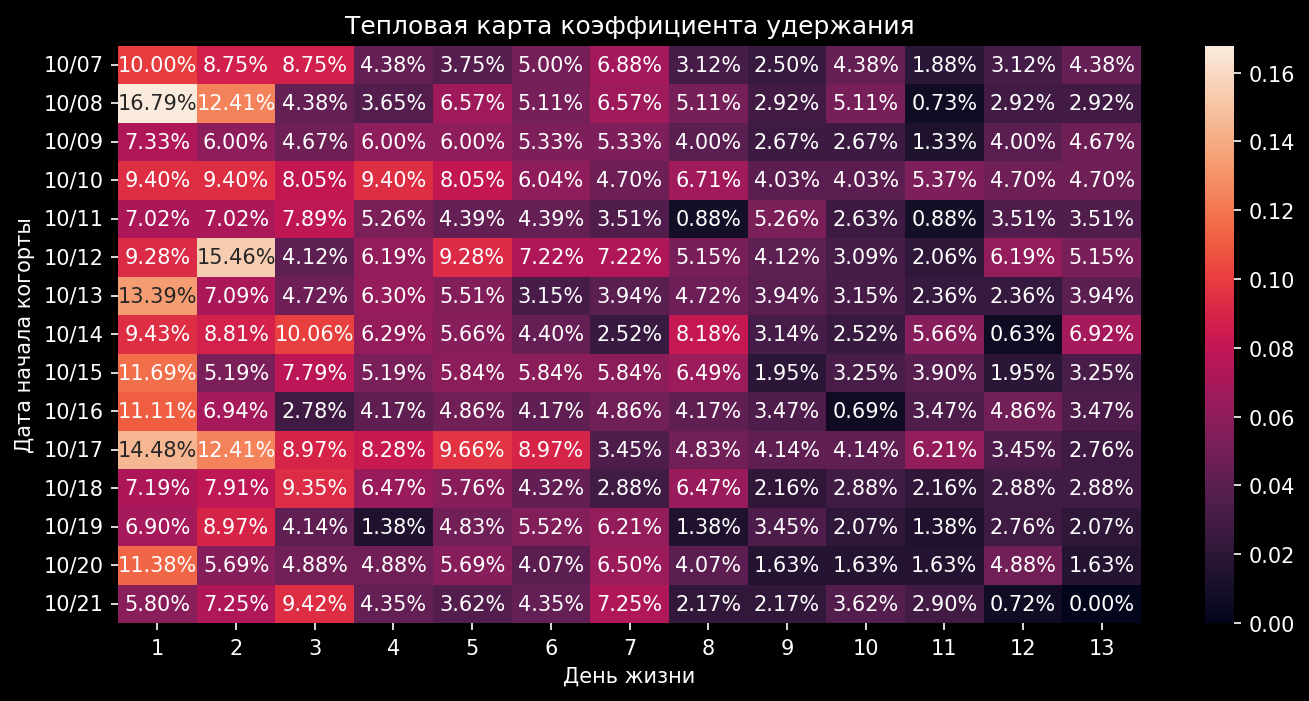

In [23]:
plt.figure(figsize=(11,5),dpi=150)
sns.heatmap(profiles_pivot.drop(['cohort_size', 0],axis=1), annot=True, fmt = '.2%')
plt.title('Тепловая карта коэффициента удержания')
plt.xlabel("День жизни")
plt.ylabel("Дата начала когорты");

Удержание через неделю менее 8%, а через 2 недели местами ниже 1%. Некоторые дни выделяются привлечение большего количества людей, но на удержании это не сказывается, через неделю эти кагорты сравниваются с остальными днями.

### DAU

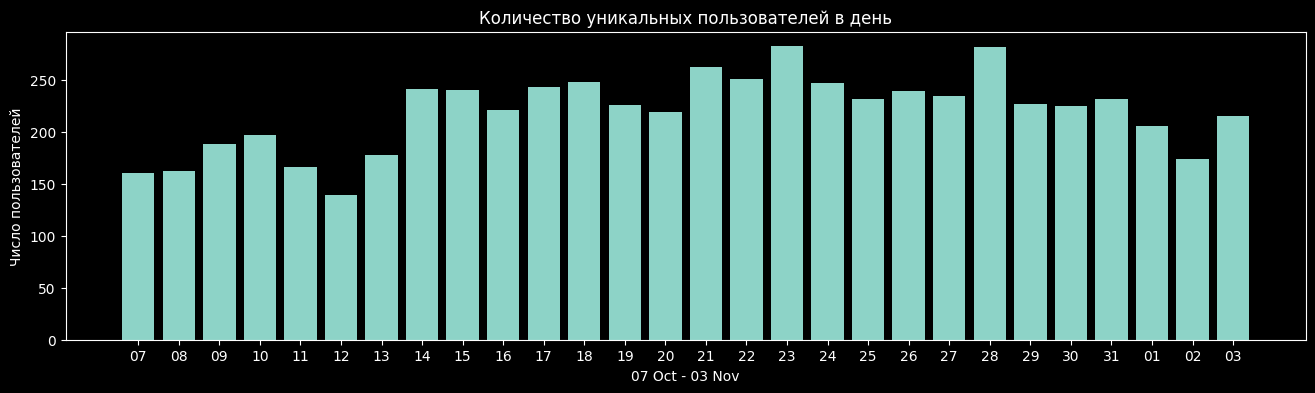

In [24]:
dau = mob.pivot_table(index=pd.DatetimeIndex(mob['event_time']).date, values='user_id', aggfunc='nunique')

plt.figure(figsize=(16,4))
plt.bar([i.strftime('%d') for i in dau.index], dau['user_id'])
plt.title('Количество уникальных пользователей в день')
plt.xlabel(str(dau.index[0].strftime('%d %b')) + ' - ' + str(dau.index[-1].strftime('%d %b')))
plt.ylabel("Число пользователей");

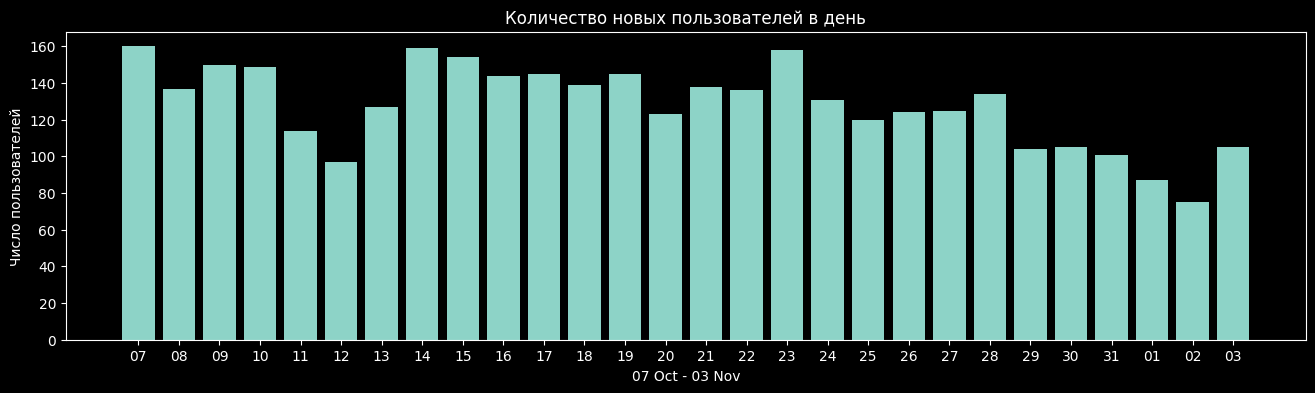

In [25]:
new_users = []
def count_new(users):
    count_new_users = 0
    for user in users:
        if user not in new_users:
            new_users.append(user)
            count_new_users += 1
    return count_new_users
new_users_pivot = mob.pivot_table(index=pd.DatetimeIndex(mob['event_time']).date, values='user_id', aggfunc=[lambda x: count_new(x)])

plt.figure(figsize=(16,4))
plt.bar([i.strftime('%d') for i in new_users_pivot.index], new_users_pivot[('<lambda>', 'user_id')])
plt.title('Количество новых пользователей в день')
plt.xlabel(str(dau.index[0].strftime('%d %b')) + ' - ' + str(dau.index[-1].strftime('%d %b')))
plt.ylabel("Число пользователей");

В целом есть тренд на увеличение уникальных пользователей. заметен наплыв новых пользователей в начале недели и провал к выходным, но в целом виден дренд на снижение новых пользователей. Возможно стоит проработать маркетинговую стратегию

### Поиск Сценариев

#### Удалим дубликаты событий в рамках одной сессии

In [26]:
mob.drop_duplicates(subset=['session_id', 'event_name'], keep='first', inplace=True, ignore_index=True)

#### Добавим столбцы с нумерацией шагов и узлами

Нам необходимы столбцы (источник -> цель), они понадобятся нам для построения диаграммы Sankey

In [27]:
# добавляем шаги
mob['step'] = mob.groupby('session_id').cumcount() + 1
# добавляем столбец цели
mob['target_event'] = mob.groupby('session_id')['event_name'].shift(-1)

# удалим все пары source-target, шаг которых превышает 7
mob = mob[mob['step'] <= 7].copy().reset_index(drop=True)

# изменим порядок столбцов для удобства
mob = mob[['session_id', 'step', 'event_time', 'user_id', 'mobile_source', 'event_name', 'target_event']]

mob.head(10)

,session_id,step,event_time,user_id,mobile_source,event_name,target_event
0,1,1,2019-10-09 18:33:55.577963,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,map,NaN
1,2,1,2019-10-21 19:53:38.767230,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,map,NaN
2,3,1,2019-10-21 19:56:49.417415,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,map,NaN
3,4,1,2019-10-22 11:18:14.635436,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,map,NaN
4,5,1,2019-10-22 11:25:33.508919,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,map,NaN
5,6,1,2019-10-19 21:34:33.849769,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,search_simple,NaN
6,7,1,2019-10-19 21:35:19.296599,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,search_simple,photos_show
7,7,2,2019-10-19 21:40:38.990477,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,photos_show,NaN
8,8,1,2019-10-19 21:42:13.837523,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,photos_show,NaN
9,9,1,2019-10-19 21:44:55.589731,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,photos_show,NaN


#### Подготовим данные для диаграммы Санкей

In [28]:
def lists_for_plot(df):
    source_indexes = {}
    count = 0

    for no, step in enumerate(df['step'].unique().tolist()):
        source_indexes[no + 1] = {
            'sources': df[df['step'] == step]['event_name'].unique().tolist(),
            'sources_index': [],
        }
        for _ in range(len(source_indexes[no+1]['sources'])):
            source_indexes[no+1]['sources_index'].append(count)
            count += 1

    for key, value_ in source_indexes.items():
        source_indexes[key]['sources_dict'] = {}
        for name, no in zip(value_['sources'], source_indexes[key]['sources_index']):
            source_indexes[key]['sources_dict'][name] = no 

    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []
    colors = {}
    for label in mob['event_name'].unique():
        r, g, b = np.random.randint(255, size=3)            
        colors[label] = f'rgba({r}, {g}, {b}, 1)'

    for step in sorted(mob['step'].unique()):
        if step + 1 not in source_indexes:
            continue

        temp_dict_source = source_indexes[step]['sources_dict']
        temp_dict_target = source_indexes[step+1]['sources_dict']

        for source, index_source in temp_dict_source.items():
            for target, index_target in temp_dict_target.items():           
                temp_df = mob[(mob['step'] == step)&(mob['event_name'] == source)&(mob['target_event'] == target)]
                value = len(temp_df)
                if value > 10:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))

    labels = []
    colors_labels = []
    for value__ in source_indexes.values():
        for name in value__['sources']:
            labels.append(name)
            colors_labels.append(colors[name])

    zip_lists = list(zip(sources, targets, values))
    perc_values = []
    unique_dict = {}

    for source, target, value in zip_lists:
        if source not in unique_dict:
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl

    for source, target, value in zip_lists:
        perc_values.append(round(100 * value / unique_dict[source], 1))

    link_text = [f"{perc}%" for perc in perc_values]
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
    
data_for_plot = lists_for_plot(mob)

#### Строим диаграмму Санкей

In [29]:
fig = go.Figure(data=[go.Sankey(
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 50,
      thickness = 15,
      line = dict(color = "black", width = 0.1),
      label = data_for_plot['labels'],
      color = data_for_plot['colors_labels']
    ),
    link = dict(
      source = data_for_plot['sources'],
      target = data_for_plot['targets'],
      value = data_for_plot['values'],
      label = data_for_plot['link_text'],
      color = data_for_plot['link_color']
  ))])
fig.update_layout(title_text="Sankey Diagram", font_size=10, width=1000, height=1000)
chart_studio.plotly.plot(fig, filename = 'Sankey_for_yandex_da_project', auto_open=False)
fig.show()

На [диаграмме](https://chart-studio.plotly.com/~PSImera/1/#plot) видно распределение основных сценариев. Примечательно что не более 4 этапов, а чаще и вовсе 2 этапа пользователю достаточно чтобы добратся до целевого - `contacts_show`.

Например:

- `search_simple` -> `photos_show` -> `contacts_show` (простой поиск -> просмотр фотографий -> посмотр контактов)

- `advert_open` -> `photos_show` - > `contacts_show` (открытие объявления -> просмотр фотографий -> посмотр контактов)

- `photos_show` - > `contacts_show` (просмотр фотографий -> посмотр контактов)

- `search_simple` -> `contacts_show` (простой поиск -> посмотр контактов)

- `search_special` -> `advert_open` -> `contacts_show` (специфический поиск -> открытие объявления -> посмотр контактов)

### Воронка событий

#### Создадим функцию для построения воронок

In [30]:
def funnel(df, n, *args):
    event = df[df['event_name'] == args[0]]
    users_ids = event['user_id'].unique()
    funnel_df = pd.DataFrame({'unique_users' : len(event['user_id'].unique()),
                        'general_users' : event.shape[0]},
                        index=[args[0]])
    
    for i in range(1, len(args)):
        event = df[(df['user_id'].isin(users_ids)) & (df['event_name'] == args[i])]
        users_ids = event['user_id'].unique()
        new_row = pd.DataFrame({'unique_users' : len(event['user_id'].unique()),
                                'general_users' : event.shape[0]},
                                index=[args[i]])
        funnel_df = pd.concat([funnel_df,new_row.loc[:]])

    fig = go.Figure(go.Funnel(y = list(funnel_df.index), x = list(funnel_df['unique_users']),
        textinfo = "value+percent initial+percent previous",
        opacity = 0.65, marker = {"color": ['teal', 'orange', 'blue', 'green', 'silver']}))

    fig.update_layout(title=dict(text=f'Воронка событий {str(n)}', x=0.5), yaxis_title='Этапы')
    chart_studio.plotly.plot(fig, filename = f'funnel_for_yandex_da_{n}', auto_open=False)
    fig.show()

#### Построим воронки

In [31]:
funnel(mob, 1, 'search_simple', 'photos_show', 'contacts_show')

[Воронка 1.](https://chart-studio.plotly.com/~PSImera/3/#/) Довольно большой процент смотрит фото после поиска, но лишь около трети потом смотрит контакты

In [32]:
funnel(mob, 2, 'advert_open', 'photos_show', 'contacts_show')

[Воронка 2.](https://chart-studio.plotly.com/~PSImera/8/#/) С карточки объявления на фотографии переходят лишь 10% пользователей, но зато из них 50% смотрят контакты, то есть люди смотрящие фотографии, чаще других, смотрят и контакты. возможно стоит более активно вовлекать людей в просмотр фотографий, а тех кто даёт объявления, стимулировать выкладывать хорошие фото

In [33]:
funnel(mob, 3, 'photos_show', 'contacts_show')

[Воронка 3.](https://chart-studio.plotly.com/~PSImera/5/#/) Если исключить поиск и с просмотра фото сразу на контакты, примерно такой же процент, около трети

In [34]:
funnel(mob, 4, 'search_simple', 'contacts_show')

[Воронка 4.](https://chart-studio.plotly.com/~PSImera/10/#/) Стандартный поиск даёт нам треть от пользователей, им воспользовавшихся, перешедших к контактам

In [35]:
funnel(mob, 5, 'search_special', 'advert_open', 'contacts_show')

[Воронка 5.](https://chart-studio.plotly.com/~PSImera/12/#/) Из специфческих вариантов поиска на карточку переходит треть, но дальше на контакты переходит лишь 1/5 из них и лишь 6% от воспользовавшихся поиском

## Проверка гипотез

### Гипотеза 1

Группа А: совершают действия `tips_show` и `tips_click`
Группа B: совершают только `tips_show`

Гипотеза: конверсия в просмотры контактов различается у этих двух групп.

Нулевая: различий в конверсии между группами А и B нет

Альтернативная: различия есть

In [36]:
tips_show_users = set(mob_with_tips_show[mob_with_tips_show['event_name'] == 'tips_show']['user_id'])
tips_click_users = set(mob_with_tips_show[mob_with_tips_show['event_name'] == 'tips_click']['user_id']) 
contacts_show_users = set(mob_with_tips_show[mob_with_tips_show['event_name'] == 'contacts_show']['user_id']) 

contacts_show_users_count_a1 = len(tips_show_users.intersection(tips_click_users, contacts_show_users))
users_count_a1 = len(tips_show_users.intersection(tips_click_users))

a1_prop = contacts_show_users_count_a1 / users_count_a1
print(f'Коэфициент конверсии в группе A: {round(a1_prop, 2)}')

users_count_b1 = tips_show_users.difference(tips_click_users )
contacts_show_users_count_b1= len(users_count_b1.intersection(contacts_show_users))
users_count_b1 = len(users_count_b1)
b1_prop = contacts_show_users_count_b1 / users_count_b1
print(f'Коэфициент конверсии в группе B: {round(b1_prop, 2)}')

p1_combined = (contacts_show_users_count_a1 + contacts_show_users_count_b1) / (users_count_a1 + users_count_b1)

alpha = .05
diff = a1_prop - b1_prop
z_value = diff / (p1_combined * (1 - p1_combined) * (1/users_count_a1 + 1/users_count_b1)) ** 0.5
distr = st.norm(0, 1) 

p_value = (1- distr.cdf(abs(z_value))) * 2
print('p-value:', round(p_value, 8))
if p_value < alpha:
    print('Отклонить нулевую гипотезу')
else:
    print('Не получилось отклонить нулевую гипотезу')

Коэфициент конверсии в группе A: 0.31
Коэфициент конверсии в группе B: 0.17
p-value: 1e-08
Отклонить нулевую гипотезу


Расзлчия статистически значимы. Отвергаем нулевую гипотезу

## Гипотеза 2

Группа A: совершают действия `photos_show` и `contacts_show`

Группа B: только `contacts_show`

Проверим гипотезу: конверсия в просмотры контактов различается у этих двух групп

Нулевая: нет различий в конверсии между группами А и B

Альтернативная: различия между группами есть

In [37]:
photos_show_users = set(mob[mob['event_name'] == 'photos_show']['user_id'])
temp = mob[~mob['user_id'].isin(photos_show_users)]
no_photos_show_users = set(temp['user_id'])
contacts_show_users = set(mob[mob['event_name'] == 'contacts_show']['user_id'])

contacts_show_users_count_a2 = len(photos_show_users.intersection(contacts_show_users))
users_count_a2 = len(photos_show_users)

a2_prop = contacts_show_users_count_a2 / users_count_a2
print(f'Коэфициент конверсии в группе A: {round(a2_prop, 2)}')

contacts_show_users_count_b2 = len(no_photos_show_users.intersection(contacts_show_users))
users_count_b2 = len(no_photos_show_users)
b2_prop = contacts_show_users_count_b2 / users_count_b2
print(f'Коэфициент конверсии в группе B: {round(b2_prop, 2)}')

p2_combined = (contacts_show_users_count_a2 + contacts_show_users_count_b2) / (users_count_a2 + users_count_b2)

alpha = .01 
diff = a2_prop - b2_prop
z_value = diff / (p2_combined * (1 - p2_combined) * (1/users_count_a2 + 1/users_count_b2)) ** 0.5
distr = st.norm(0, 1) 

p_value = (1- distr.cdf(abs(z_value))) * 2
print('p-value:', round(p_value, 8))
if p_value < alpha:
    print('Отклонить нулевую гипотезу')
else:
    print('Не получилось отклонить нулевую гипотезу')

Коэфициент конверсии в группе A: 0.31
Коэфициент конверсии в группе B: 0.26
p-value: 0.00133425
Отклонить нулевую гипотезу


Не смотря на то что значения в 31% и 26% кажуться близкими, тест показывает что это различие статистически значимо и пользователи, просмотревшие фотографии, чаще конверсируются в просмотр контактов

## Вывод

Что было сделано:

Была проанализирована связь целевого события `просмотр контактов` и других действий пользователя.

для этого поэтапно были осуществленны следующие действия:

* Произведена предобработка данных, включающая;
    * переименование столбцов
    * преобразование типа данных столбца `event_time` в формат даты и время
    * удаление неявных дубликатов в виде событий `contacts_show` и `show_contacts`

* Анализ данных;
    * В нашем распоряжении информация с `07 Oct 2019` по `03 Nov 2019`, то есть почти за месяц. Данные начинаются с понедельника.
    * Конверсия к целевому событию составляет 22.85% от общего количества пользователей
    * Было решено исключить событие `tips_show`, поскольку оно является автоматическим и не отражает активности пользователей. Однако, оно было использованно для проверки гипотезы, данной в ТЗ.
    * События связанные с поиском встречаются очень редко. Единственное событие `search_1`, встречающееся достаточно часто, было объявлено как `search_simple`. Остальные было решено рассматривать как категорию `search_special`, предположительно связанных с использованием фильтров.
    * На одного пользователя в среднем приходится 16 событий при минимуме и максимуме в 1 и 336 событий. С таким большим разбросом, полезнее будет рассматривать медиану, которая составляет 5 событий на пользователя.
    * По распределению показателей среди источников пользователей лидирует Yandex. Больше всего пользователей и пришедшие пользователи осуществляют больше событий. Google даёт меньше уникальных пользователей чем остальные источники (не считая Yandex), но эти пользователи чуть более активны
    * Есть явная суточная сезонность. Ночью приложением пользуются значительно реже и пик приходится на 9 вечера. Так же есть провал в 5-6 вечера
    * Ввиду небольшого отрезка данных по времени, решено было не делать декомпозицию и не выявлять тренды
    * Наблюдается более частое посещение приложения во вторник и воскресенье, и наименьшее в пятницу и субботу.
    * Сессию анализировали взяв интервал бездействия в 20 минут, опираясь на стандарты [OWASP (Open Web Application Security Project)](https://cheatsheetseries.owasp.org/cheatsheets/Session_Management_Cheat_Sheet.html#:~:text=Both%20the%20idle,and%208%20hours)
    * Основная масса людей пользуется приложением до 2 минут 1-4 раз в день.
    * Когортный анализ показал низкий показатель удержания пользователей. Например, удержание к 7-му дню составило менее 8%, а к 14-му дню - менее 1%.
    * Количество новых пользователей в день имеет тенденцию к снижению. при небольшом росте количества уникальных пользователей.
    * На диаграмме Санкей рассмотрено распределение основных сценариев. Примечательно что сценарии составляют не более 4 этапов, а чаще и вовсе 2 этапа пользователю достаточно чтобы добратся до целевого - `contacts_show`.
    * выделены следующие сценарии и проанализированны их воронки:
        * `простой поиск -> просмотр фотографий -> посмотр контактов` - Довольно большой процент смотрит фото после поиска, но лишь около трети потом смотрит контакты
        * `открытие объявления -> просмотр фотографий -> посмотр контактов` - С карточки объявления на фотографии переходят лишь 10% пользователей, но зато из них 50% смотрят контакты, то есть люди смотрящие фотографии, чаще других, смотрят и контакты. возможно стоит более активно вовлекать людей в просмотр фотографий, а тех кто даёт объявления, стимулировать выкладывать хорошие фото
        * `просмотр фотографий -> посмотр контактов` - Если исключить поиск и с просмотра фото сразу на контакты, примерно такой же процент, около трети
        * `простой поиск -> посмотр контактов` - Стандартный поиск даёт нам треть от пользователей, им воспользовавшихся, перешедших к контактам
        * `специфический поиск -> открытие объявления -> посмотр контактов` - Из специфческих вариантов поиска на карточку переходит треть, но дальше на контакты переходит лишь 1/5 из них и лишь 6% от воспользовавшихся поиском

* Проверенны гипотезы:
    * Статистически значимые различия обнаружены в конверсии пользователей, совершающих действия `tips_show` и `tips_click` по сравнению с пользователями, совершающими только `tips_show`. Конверсия выше у первой группы
    * Обнаружены статистически значимые различия в конверсии пользователей, просматривающих фото и не просматривающих их. Конверсия выше в первой группе (31% против 26%)


Рекомендации:

* Рекомендуется добавить логирование действия "стартовая страница". Это поможет улучшить точность учета пользователей и стать отправной точкой для большинства аналитических воронок. Также станет проще отслеживать частоту заходов пользователей в приложение в разное время
* Следует уделить внимание развитию системы рекомендаций
* Необходимо привести базу данных к общему формату, чтобы избежать дублирования событий `contacts_show` и `show_contacts`
* Рекомендуется переименовать события от `search_1` до `search_7` в более интуитивно понятные названия или документировать их значения